# Ideal neighborhoods under KMC to open a restaurant

*A entrepreneur wants to set up a fast food restaurant in Kolkata. The business problem is to analyze the neighbourhoods and cluster them such that a head start can be made in terms of shortlisting neighborhoods to open the restaurant in*

### K Means clustering have been used for clustering the neighborhoods under KMC

*The factors the have been taken into account while creating the model are*

**Total Population** - *More the Population, more chance of sales, better suited to open a restaurant*

**Literacy rate** -  *As a proxy for Spending power i.e. more Spending power(literacy rate), more chance of sales, better to open a restaurant*

**No. of restaurants** - *More restaurants in the ward, more competition, less favourable to open*

**Pop. Below 6 years** - *More pop. below 6 years, more youth in future, more fast food sales growth in future*

In [1]:
#Importing all requisite packages

import pandas as pd
import numpy as np
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
import folium

#### Data scrapped for wards from https://en.wikipedia.org/wiki/Category:Municipal_wards_of_Kolkata into a csv file

In [38]:
neighborhoods=pd.read_csv('C:/Users/Gaurav/Desktop/IP/Data Science/Projects/Kolkata_tutorial/Ward_data.csv')
neighborhoods.head()

,Ward No.,Area,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate
0,1,Cossipore,22.617889,88.370556,4033,53125.0,86.41%
1,2,Sinthee,22.628056,88.384444,2575,48190.0,94.24%
2,3,Belgachia,22.604444,88.383333,4358,53855.0,86.74%
3,4,Paikpara,22.613056,88.379444,2144,34476.0,89.27%
4,5,Tala,22.608889,88.379694,1485,23707.0,90.32%


### Creating a map of KMC with all the wards plotted

In [3]:
# create map of Kolkata using latitude and longitude values
latitude=22.5726
longitude=88.3639
map_Kolkata = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Ward, neighborhood in zip(neighborhoods['Latitiude'], neighborhoods['Longitude'], neighborhoods['Ward No.'], neighborhoods['Area']):
    label = '{}, {}'.format(neighborhood, Ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Kolkata)  
    
map_Kolkata

## Using Foursquare API (explore function) to fetch restaurant details for the different wards

*Foursquare API sets a limitation on number of requests. Therefore, limit was put to 100 per ward*

#### Foursquare credentials

In [5]:
CLIENT_ID = 'SJG42ZQRUW3A3YLO4TLEDNY2HT52GNZKFYGIWOLNI1DLW2GS' 
CLIENT_SECRET = 'NTGFU1PDVFIO5QM0TQSTOLH1JBEUA05RJTGUH2FMROFXW0KX' 
VERSION = '20180605' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SJG42ZQRUW3A3YLO4TLEDNY2HT52GNZKFYGIWOLNI1DLW2GS
CLIENT_SECRET:NTGFU1PDVFIO5QM0TQSTOLH1JBEUA05RJTGUH2FMROFXW0KX


**Function to get nearby venues for each wards**

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [3]:
Kolkata_venues = getNearbyVenues(names=neighborhoods['Area'],
                                   latitudes=neighborhoods['Latitiude'],
                                  longitudes=neighborhoods['Longitude']
                                 )

### Taking only those wards where foursquare API returned restaurant data for analysis. 

One limitation of the model as restaurant data is not exhaustive in foursquare and limit on the number of responses. Further enhancement can be done with more data for the other wards

In [4]:
Val_venues = Kolkata_venues[Kolkata_venues['Venue Category'].str.contains(r'Restaurant|Pizza|Burger|Food|Dhaba|Bakery|Dessert|Caf|Sweet|Bakery')]
Val_venues.rename(columns={'Neighborhood':'Area'},inplace=True)
Val_onehot = pd.DataFrame(Val_venues['Area'].value_counts())
Val_onehot.rename(columns={'Area':'No. of restaurants'},inplace=True)
Val_onehot.index.name='Area'
Val_onehot

H:\Data Science\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,No. of restaurants
Area,
Jadubabubazar,13
Beck Bagan,12
Park Street,12
Gariahat,10
Jodhpur Park,10
...,...
Girish Park,1
Metiabruz 2,1
Sree Colony,1


In [28]:
Kolkata_1 = pd.merge(Val_onehot, neighborhoods, on='Area')
Kolkata = Kolkata_1.drop(['Latitiude', 'Longitude','Ward No.',], axis = 1)
Kolkata['Literacy rate'] = Kolkata['Literacy rate'].str.rstrip('%').astype('float') / 100.0
Kolkata

,Area,No. of restaurants,Pop. Below 6 years,Total Population,Literacy rate
0,Jadubabubazar,13,935,18618.0,0.9420
1,Beck Bagan,12,2755,31280.0,0.8521
2,Park Street,12,1376,24387.0,0.8439
3,Gariahat,10,1051,19195.0,0.8961
4,Jodhpur Park,10,2798,44364.0,0.9130
...,...,...,...,...,...
72,Girish Park,1,1556,27484.0,0.8549
73,Metiabruz 2,1,3889,30504.0,0.7993
74,Sree Colony,1,1519,26739.0,0.9579
75,Rania roy nagar,1,2345,32404.0,0.9250


### Exploratory Data analysis

#### Distribution of types of restaurants in different wards

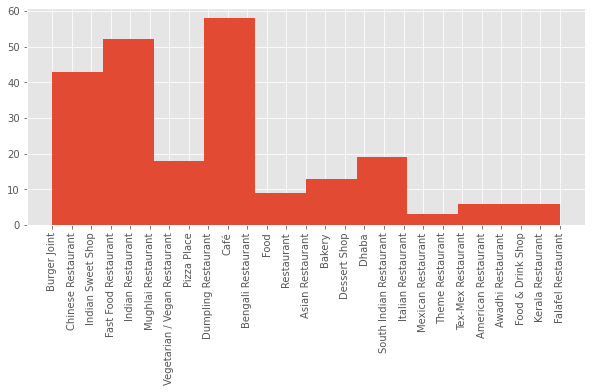

In [67]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.hist(Val_venues['Venue Category'],bins=10)
plt.xticks(rotation='vertical')
plt.show()

#### Scatter plot of Total Population vs No. of restaurants

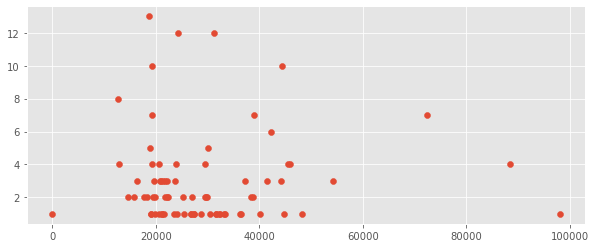

In [68]:
matplotlib.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.scatter(Kolkata_1['Total Population'],Kolkata_1['No. of restaurants'])
plt.show()

#### Scatter plot of Pop.below 6 years vs No. of restaurants

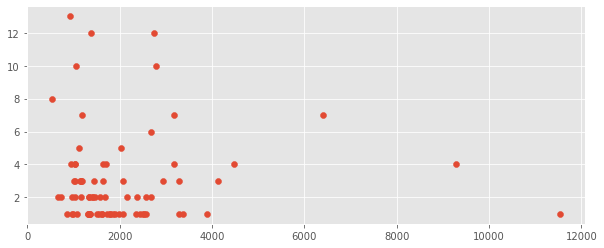

In [69]:
matplotlib.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.scatter(Kolkata_1['Pop. Below 6 years'],Kolkata_1['No. of restaurants'])
plt.show()

### Normalization of the data using Standard Scaler function

For mathematical-based algorithms, to interpret features with different magnitudes and distributions equally, we will have to normalize our data; Using Standard scaler function to normalize the data

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Kolkata.iloc[:,[1,2,3]]=scaler.fit_transform(Kolkata.iloc[:,[1,2,3]])


In [30]:
Kolkata

,Area,No. of restaurants,Pop. Below 6 years,Total Population,Literacy rate
0,Jadubabubazar,3.612596,-0.683181,-0.724570,0.9420
1,Beck Bagan,3.251336,0.395737,0.114047,0.8521
2,Park Street,3.251336,-0.421751,-0.342483,0.8439
3,Gariahat,2.528817,-0.614415,-0.686355,0.8961
4,Jodhpur Park,2.528817,0.421227,0.980614,0.9130
...,...,...,...,...,...
72,Girish Park,-0.722519,-0.315045,-0.137366,0.8549
73,Metiabruz 2,-0.722519,1.067985,0.062652,0.7993
74,Sree Colony,-0.722519,-0.336979,-0.186708,0.9579
75,Rania roy nagar,-0.722519,0.152684,0.188491,0.9250


## Running K-means clustering algorithm wtih k=6 

In [32]:
# set number of clusters
kclusters = 6

Kolkata_clustering = Kolkata.drop('Area', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Kolkata_clustering)

# check cluster labels generated for each row in the dataframe
Kolkata_1['kmeans_label']=kmeans.labels_[0:]

In [35]:
Kolkata_1['kmeans_label']=kmeans.labels_[0:]
Kolkata_1

,Area,No. of restaurants,Ward No.,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate,kmeans_label
0,Jadubabubazar,13,70,22.537889,88.350472,935,18618.0,94.20%,3
1,Beck Bagan,12,64,22.541217,88.364333,2755,31280.0,85.21%,3
2,Park Street,12,63,22.546639,88.352444,1376,24387.0,84.39%,3
3,Gariahat,10,86,22.518917,88.364306,1051,19195.0,89.61%,3
4,Jodhpur Park,10,93,22.504833,88.363694,2798,44364.0,91.30%,3
...,...,...,...,...,...,...,...,...,...
72,Girish Park,1,25,22.587761,88.361251,1556,27484.0,85.49%,1
73,Metiabruz 2,1,139,22.546806,88.261556,3889,30504.0,79.93%,0
74,Sree Colony,1,99,22.481833,88.371694,1519,26739.0,95.79%,1
75,Rania roy nagar,1,112,22.476833,88.365694,2345,32404.0,92.50%,0


## Plotting the map again with Clustered data

In [37]:
# create map
latitude=22.5726
longitude=88.3639
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Kolkata_1['Latitiude'], Kolkata_1['Longitude'], Kolkata_1['Area'], Kolkata_1['kmeans_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster analysis

#### Cluster 1

Total Population - **MID**

Literacy rate - **MID**

No. of restaurants - **LOW**

Pop. Below 6 years - **LOW**

In [40]:
Kolkata_1.loc[Kolkata_1['kmeans_label'] == 0].head()

,Area,No. of restaurants,Ward No.,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate,kmeans_label
20,New Alipore 2,3,81,22.504500,88.335611,2947,41501.0,85.14%,0
28,Ballygunge 2,3,69,22.529889,88.359472,3283,44111.0,86.07%,0
29,Regent Park,3,97,22.487833,88.348694,2073,37199.0,94.60%,0
32,Chetla,2,82,22.517845,88.335611,2583,38838.0,84.82%,0
38,Tiretta Bazaar,2,44,22.574889,88.357361,2384,29600.0,79.09%,0


#### Cluster 2


Total Population - **LOW**

Literacy rate - **MID**

No. of restaurants - **LOW**

Pop. Below 6 years - **LOW**

In [41]:
Kolkata_1.loc[Kolkata_1['kmeans_label'] == 1].head()

,Area,No. of restaurants,Ward No.,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate,kmeans_label
21,Fariapukur,3,12,22.596806,88.376694,1455,21493.0,84.95%,1
22,James long sarani,3,120,22.496833,88.319806,1151,19710.0,92.15%,1
24,Barabazar,3,42,22.580313,88.352673,1018,21746.0,75.02%,1
25,Darjipara,3,17,22.595378,88.365556,1160,21023.0,92.30%,1
26,Goa Bagan,3,16,22.591278,88.371361,1164,20904.0,88.82%,1


#### Cluster 3


Total Population - **HIGH**

Literacy rate - **LOW**

No. of restaurants - **LOW**

Pop. Below 6 years - **HIGH**

In [42]:
Kolkata_1.loc[Kolkata_1['kmeans_label'] == 2].head()

,Area,No. of restaurants,Ward No.,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate,kmeans_label
14,Mathpukur,4,58,22.543333,88.397250,9277,88465.0,74.35%,2
70,Science city,1,66,22.531861,88.385544,11526,98024.0,80.95%,2


#### Cluster 4

Total Population - **LOW**

Literacy rate - **HIGH**

No. of restaurants - **HIGH**

Pop. Below 6 years - **LOW**

In [43]:
Kolkata_1.loc[Kolkata_1['kmeans_label'] == 3].head()

,Area,No. of restaurants,Ward No.,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate,kmeans_label
0,Jadubabubazar,13,70,22.537889,88.350472,935,18618.0,94.20%,3
1,Beck Bagan,12,64,22.541217,88.364333,2755,31280.0,85.21%,3
2,Park Street,12,63,22.546639,88.352444,1376,24387.0,84.39%,3
3,Gariahat,10,86,22.518917,88.364306,1051,19195.0,89.61%,3
4,Jodhpur Park,10,93,22.504833,88.363694,2798,44364.0,91.30%,3


#### Cluster 5


Total Population - **HIGH**

Literacy rate - **MID**

No. of restaurants - **MID**

Pop. Below 6 years - **HIGH**

In [71]:
Kolkata_1.loc[Kolkata_1['kmeans_label'] == 4]

,Area,No. of restaurants,Ward No.,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate,kmeans_label
6,Ballygunge,7,65,22.531667,88.368444,6400,72427.0,81.40%,4
7,Kadapara,7,31,22.579861,88.388971,3186,39025.0,88.28%,4
9,Alipore,6,74,22.525889,88.330472,2675,42176.0,84.56%,4
15,Sudhir Bose Road,4,77,22.536944,88.323861,4469,45984.0,83.84%,4
18,Kankurgachi,4,32,22.582861,88.391917,3189,45636.0,75.73%,4
23,Tiljala,3,107,22.514833,88.397694,4129,54260.0,90.06%,4


#### Cluster 6

Total Population - **LOW**

Literacy rate - **MID**

No. of restaurants - **HIGH**

Pop. Below 6 years - **MID**

In [70]:
Kolkata_1.loc[Kolkata_1['kmeans_label'] == 5]

,Area,No. of restaurants,Ward No.,Latitiude,Longitude,Pop. Below 6 years,Total Population,Literacy rate,kmeans_label
5,Lake market,8,87,22.513917,88.350694,544,12675.0,90.26%,5
8,Manoharpukur,7,84,22.518435,88.349417,1187,19230.0,85.71%,5
10,Rashbehari 2,5,90,22.514222,88.366694,1131,18857.0,84.60%,5
11,Phoolbagan,5,30,22.576250,88.387528,2038,30050.0,88.71%,5
12,Ekdalia,4,68,22.521889,88.368472,1036,20724.0,90.86%,5
13,Dharmatala,4,46,22.567250,88.350722,956,12823.0,85.38%,5
16,Maniktala,4,15,22.590278,88.376556,1633,23992.0,88.89%,5
17,Maniktala,4,27,22.585250,88.372333,1045,19350.0,88.19%,5
19,Deshapriya Park,4,85,22.521141,88.356506,1700,29566.0,88.19%,5
